# Classification of Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Для начала загружаем датасет:

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
resize = keras.layers.Resizing(224, 224)
def normalize_img(image, label):
    return tf.cast(resize(image), tf.float32), label

In [3]:
train, test = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJVAM3U/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteJVAM3U/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
train = train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(len(train))

test = test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

Для визуализации изображений используйте функцию:

In [ ]:
from PIL import Image

def display_images(data, max_n = 8):
    n = min(max_n, len(data[0]))
    fig, ax = plt.subplots(1, n)
    for i in range(n):
        img = data[0][i]
        ax[i].imshow(img/255.)
        ax[i].axis("off")
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

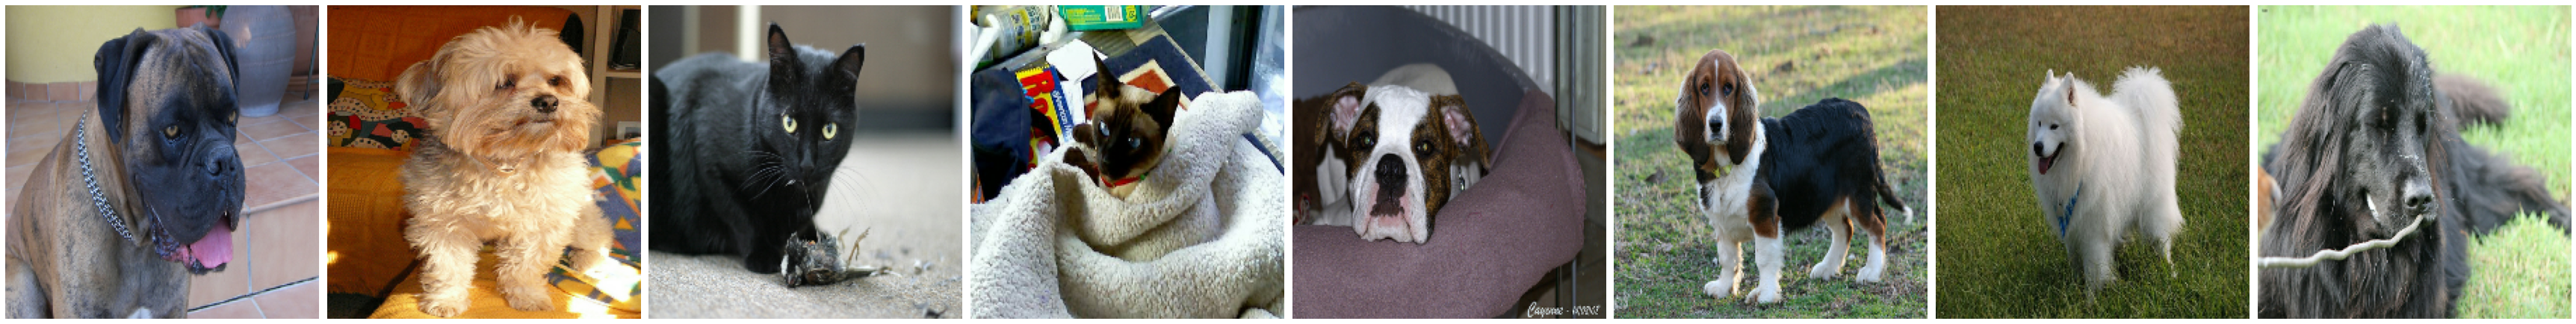

In [ ]:
display_images(next(iter(train.batch(8))))

In [29]:
CATS = tf.constant([0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33], dtype=tf.int32)

class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros", dtype=tf.int32)
        
    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape, dtype=tf.int32))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(tf.math.confusion_matrix(y_true, tf.argmax(y_pred, axis=1)))
        return self.total_cm
        
    def result(self):
        return self.total_cm

confusion_matrix = ConfusionMatrixMetric(37)

def plot(model, h, test):
    confusion_matrix.reset_state()
    for x, y in test:
        confusion_matrix.update_state(y, model(x))

    print("Accuracy:", h.history['val_accuracy'][-1])
    print("Top-3 accuracy:", h.history['val_top_3'][-1])
    print("Top-5 accuracy:", h.history['val_top_5'][-1])
    print("Binary accuracy:", h.history['val_bin_accuracy'][-1])
    
    figure = plt.figure(figsize=(20, 4))
    axes = figure.add_subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    matr = axes.imshow(confusion_matrix.result())
    figure.colorbar(matr)
    axes = figure.add_subplot(1, 3, 2)
    epochs = range(1, len(h.history['accuracy'])+1)
    plt.xticks(epochs)
    plt.plot(epochs, h.history['accuracy'], 'k--')
    plt.plot(epochs, h.history['val_accuracy'], 'g-')
    axes = figure.add_subplot(1, 3, 3)
    plt.xticks(range(1, len(h.history['accuracy'])+1))
    plt.plot(epochs, h.history['val_top_3'], label='Top 3')
    plt.plot(epochs, h.history['val_top_5'], label='Top 5')
    plt.plot(epochs, h.history['val_bin_accuracy'], label='Bin')
    axes.legend()
    plt.show()

def bin_accuracy(labels, pred):
    correct = 0
    for i in range(len(labels)):
        if tf.experimental.numpy.any(tf.cast(tf.argmax(pred[i]), tf.int32) == CATS) == tf.experimental.numpy.any(tf.cast(labels[i][0], tf.int32) == CATS):
            correct += 1
    return correct / len(labels)

In [6]:
augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation([-0.125, 0.125]),
])

aug_train = train.map(lambda x, y: (augmentation(x), y))

In [7]:
metrics = ['accuracy', keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3"), keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5"), bin_accuracy]

In [8]:
vgg = keras.applications.VGG16(include_top=False, input_shape=(224,224,3))
for x in vgg.layers:
    x.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
train = train.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(128)
aug_train = aug_train.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(128)
test = test.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(128)

In [14]:
model = keras.models.Sequential([
    vgg,
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dense(37)
])

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 37)                151589    
                                                                 
Total params: 134,412,133
Trainable params: 119,697,445
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/10
29/29 [==============================] - 39s 1s/step - loss: 3.0973 - accuracy: 0.1840 - top_3: 0.6338 - top_5: 0.7142 - bin_accuracy: 0.7720 - val_loss: 2.3505 - val_accuracy: 0.3919 - val_top_3: 0.6481 - val_top_5: 0.7544 - val_bin_accuracy: 0.9076
Epoch 2/10
29/29 [==============================] - 39s 1s/step - loss: 0.8680 - accuracy: 0.9378 - top_3: 0.9859 - top_5: 0.9937 - bin_accuracy: 0.9914 - val_loss: 1.7199 - val_accuracy: 0.5661 - val_top_3: 0.8084 - val_top_5: 0.8825 - val_bin_accuracy: 0.9535
Epoch 3/10
29/29 [==============================] - 40s 1s/step - loss: 0.2931 - accuracy: 0.9981 - top_3: 0.9997 - top_5: 1.0000 - bin_accuracy: 1.0000 - val_loss: 1.5022 - val_accuracy: 0.6261 - val_top_3: 0.8482 - val_top_5: 0.9128 - val_bin_accuracy: 0.9609
Epoch 4/10
29/29 [==============================] - 39s 1s/step - loss: 0.1490 - accuracy: 0.9997 - top_3: 1.0000 - top_5: 1.0000 - bin_accuracy: 1.0000 - val_loss: 1.4010 - val_accuracy: 0.6479 - val_top_3: 0.8624

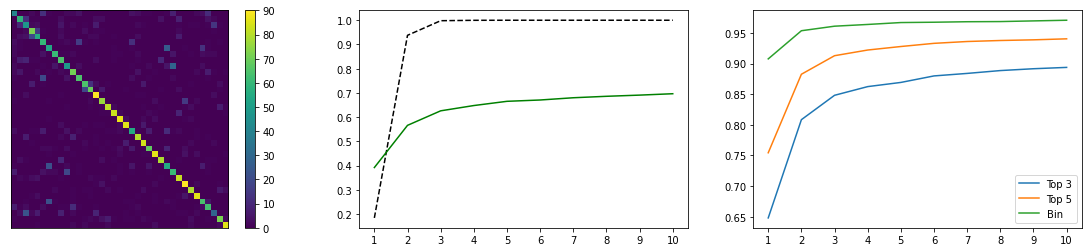

In [15]:
model.compile(tf.keras.optimizers.Adam(0.00001), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics)
h = model.fit(train, epochs = 10, validation_data = test)
plot(model, h, test)

Epoch 1/20
29/29 [==============================] - 59s 2s/step - loss: 3.3133 - accuracy: 0.1332 - top_3: 0.5244 - top_5: 0.5989 - bin_accuracy: 0.7253 - val_loss: 2.4876 - val_accuracy: 0.3461 - val_top_3: 0.5912 - val_top_5: 0.7133 - val_bin_accuracy: 0.8921
Epoch 2/20
29/29 [==============================] - 57s 2s/step - loss: 2.1129 - accuracy: 0.4698 - top_3: 0.7035 - top_5: 0.7948 - bin_accuracy: 0.9100 - val_loss: 1.6948 - val_accuracy: 0.5675 - val_top_3: 0.8168 - val_top_5: 0.8899 - val_bin_accuracy: 0.9555
Epoch 3/20
29/29 [==============================] - 57s 2s/step - loss: 1.4726 - accuracy: 0.6424 - top_3: 0.8633 - top_5: 0.9193 - bin_accuracy: 0.9502 - val_loss: 1.3019 - val_accuracy: 0.6680 - val_top_3: 0.8842 - val_top_5: 0.9362 - val_bin_accuracy: 0.9702
Epoch 4/20
29/29 [==============================] - 58s 2s/step - loss: 1.1138 - accuracy: 0.7476 - top_3: 0.9155 - top_5: 0.9552 - bin_accuracy: 0.9721 - val_loss: 1.0890 - val_accuracy: 0.7198 - val_top_3: 0.9139

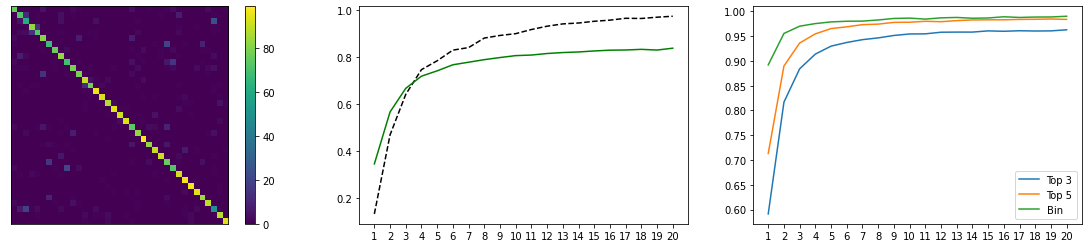

In [17]:
model = keras.models.Sequential([
    vgg,
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dense(37)
])

model.compile(tf.keras.optimizers.Adam(0.00001), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics)
h = model.fit(aug_train, epochs = 20, validation_data = test)
plot(model, h, test)

In [18]:
resnet = keras.applications.ResNet50(include_top=False, input_shape=(224,224,3))
for x in resnet.layers:
    x.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [19]:
train = train.unbatch().map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(128)
aug_train = aug_train.unbatch().map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(128)
test = test.unbatch().map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(128)

In [20]:
model = keras.models.Sequential([
    resnet,
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='tanh'),
    keras.layers.Dense(37)
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 4096)              411045888 
                                                                 
 dense_13 (Dense)            (None, 37)                151589    
                                                                 
Total params: 434,785,189
Trainable params: 411,197,477
Non-trainable params: 23,587,712
_________________________________________________________________


Epoch 1/10
29/29 [==============================] - 64s 2s/step - loss: 2.0525 - accuracy: 0.4356 - top_3: 0.8061 - top_5: 0.8600 - bin_accuracy: 0.8854 - val_loss: 1.1535 - val_accuracy: 0.6318 - val_top_3: 0.8678 - val_top_5: 0.9291 - val_bin_accuracy: 0.9578
Epoch 2/10
29/29 [==============================] - 41s 1s/step - loss: 0.0654 - accuracy: 0.9935 - top_3: 0.9995 - top_5: 0.9997 - bin_accuracy: 0.9992 - val_loss: 0.9959 - val_accuracy: 0.6817 - val_top_3: 0.8902 - val_top_5: 0.9441 - val_bin_accuracy: 0.9662
Epoch 3/10
29/29 [==============================] - 41s 1s/step - loss: 0.0128 - accuracy: 1.0000 - top_3: 1.0000 - top_5: 1.0000 - bin_accuracy: 1.0000 - val_loss: 0.9625 - val_accuracy: 0.6896 - val_top_3: 0.8981 - val_top_5: 0.9482 - val_bin_accuracy: 0.9678
Epoch 4/10
29/29 [==============================] - 41s 1s/step - loss: 0.0078 - accuracy: 1.0000 - top_3: 1.0000 - top_5: 1.0000 - bin_accuracy: 1.0000 - val_loss: 0.9525 - val_accuracy: 0.6928 - val_top_3: 0.8994

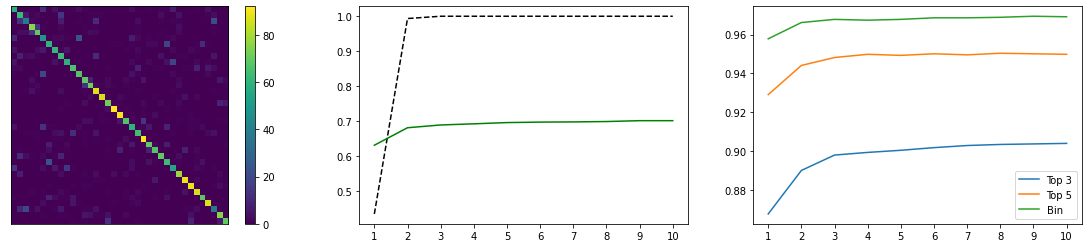

In [21]:
model.compile(tf.keras.optimizers.Adam(0.00001), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics)
h = model.fit(train, epochs = 10, validation_data = test)
plot(model, h, test)

Epoch 1/10
29/29 [==============================] - 81s 3s/step - loss: 2.9878 - accuracy: 0.2182 - top_3: 0.6495 - top_5: 0.7268 - bin_accuracy: 0.7812 - val_loss: 2.1067 - val_accuracy: 0.4666 - val_top_3: 0.7108 - val_top_5: 0.8149 - val_bin_accuracy: 0.9340
Epoch 2/10
29/29 [==============================] - 61s 2s/step - loss: 1.6926 - accuracy: 0.6008 - top_3: 0.8160 - top_5: 0.8864 - bin_accuracy: 0.9395 - val_loss: 1.4851 - val_accuracy: 0.5996 - val_top_3: 0.8397 - val_top_5: 0.9117 - val_bin_accuracy: 0.9592
Epoch 3/10
29/29 [==============================] - 61s 2s/step - loss: 1.2021 - accuracy: 0.7212 - top_3: 0.9041 - top_5: 0.9446 - bin_accuracy: 0.9582 - val_loss: 1.2349 - val_accuracy: 0.6618 - val_top_3: 0.8733 - val_top_5: 0.9324 - val_bin_accuracy: 0.9682
Epoch 4/10
29/29 [==============================] - 61s 2s/step - loss: 0.9336 - accuracy: 0.7832 - top_3: 0.9361 - top_5: 0.9679 - bin_accuracy: 0.9685 - val_loss: 1.0903 - val_accuracy: 0.6874 - val_top_3: 0.8929

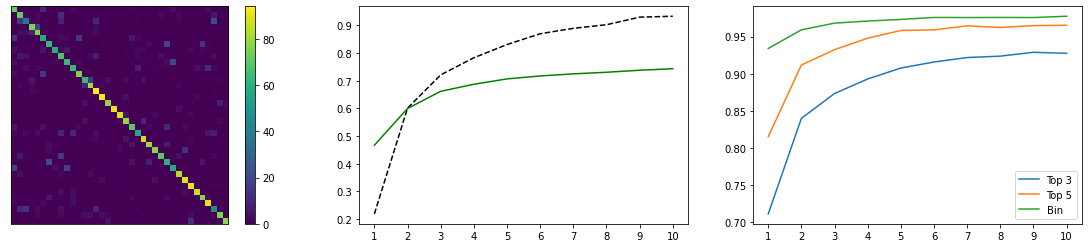

In [22]:
model2 = keras.models.Sequential([
    resnet,
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(37)
])

model2.compile(tf.keras.optimizers.Adam(0.00001), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics)
h = model2.fit(aug_train, epochs = 10, validation_data = test)
plot(model2, h, test)

Epoch 1/10
29/29 [==============================] - 81s 3s/step - loss: 5.1079 - accuracy: 0.0614 - top_3: 0.5442 - top_5: 0.6039 - bin_accuracy: 0.6351 - val_loss: 4.0388 - val_accuracy: 0.1368 - val_top_3: 0.3053 - val_top_5: 0.4197 - val_bin_accuracy: 0.7632
Epoch 2/10
29/29 [==============================] - 61s 2s/step - loss: 3.5133 - accuracy: 0.1997 - top_3: 0.3818 - top_5: 0.5095 - bin_accuracy: 0.7766 - val_loss: 2.9903 - val_accuracy: 0.2690 - val_top_3: 0.5083 - val_top_5: 0.6372 - val_bin_accuracy: 0.8499
Epoch 3/10
29/29 [==============================] - 61s 2s/step - loss: 2.6153 - accuracy: 0.3277 - top_3: 0.5679 - top_5: 0.6927 - bin_accuracy: 0.8396 - val_loss: 2.4364 - val_accuracy: 0.3677 - val_top_3: 0.6247 - val_top_5: 0.7490 - val_bin_accuracy: 0.8982
Epoch 4/10
29/29 [==============================] - 61s 2s/step - loss: 2.0624 - accuracy: 0.4226 - top_3: 0.6840 - top_5: 0.7899 - bin_accuracy: 0.8886 - val_loss: 2.1021 - val_accuracy: 0.4437 - val_top_3: 0.6991

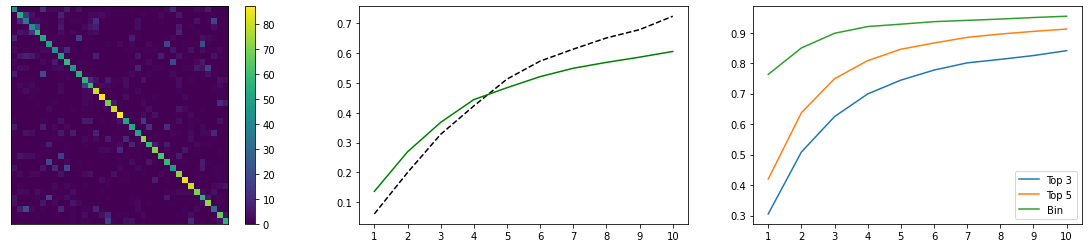

In [23]:
model3 = keras.models.Sequential([
    resnet,
    keras.layers.Flatten(),
    keras.layers.Dense(37)
])

model3.compile(tf.keras.optimizers.Adam(0.00001), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics)
h = model3.fit(aug_train, epochs = 10, validation_data = test)
plot(model3, h, test)